<a href="https://colab.research.google.com/github/ashuonnet/ailearn/blob/main/BERT_Skills_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textblob
!pip install sentence_transformers
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import pandas as pd
from textblob import TextBlob
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from bertopic.representation import MaximalMarginalRelevance


import nltk
nltk.download('stopwords')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
%%time
dfs = []
seed_topic_list = []

verticals = ["hardware_asic","cloud_computing","data_science","devops","embedded","it_support","network","project_mgmt","web","info_security"]
#verticals = ["hardware_asic"]

for vertical in verticals:
  #file = vertical+'.xlsx'
  temp_df = pd.read_excel(f'{vertical}.xlsx')
  dfs.append(temp_df)

  #check all the skills keyword and prepare seeds
  temp_df.fillna('', inplace=True)
  temp_df['skills']  = temp_df['skills'].str.lower()
  skills = temp_df.skills.tolist()
  skills = list(filter(None, skills))

  temp_skills = [x.split(',') for x in skills]
  unique_skills = []
  for x in temp_skills:
    unique_skills = unique_skills+x
  
  unique_skills = [x.strip() for x in unique_skills if x.strip() != '']

  #clean null values from list
  unique_skills = list(set(unique_skills))
  if(len(unique_skills) !=0):
    seed_topic_list.append(unique_skills)
  else:
    print("Could not see - ",vertical)

  del temp_df

df = pd.concat(dfs, sort=False, ignore_index=True)
del dfs

Could not see -  project_mgmt
CPU times: user 2.83 s, sys: 56.4 ms, total: 2.88 s
Wall time: 3.34 s


In [4]:
seed_topic_list

[['websphere',
  'kernel upgrades',
  'process compliance',
  'rtc',
  'authorization',
  'algorithms',
  'dcs',
  'appointing channel partner',
  'i2s',
  'arm',
  'operations',
  'i2c communication protocol',
  'project planning',
  'iso 16750',
  'principal',
  'journalism',
  'banking',
  'electrical installation',
  'team lead',
  'fpga design',
  'troubleshoots',
  'web development',
  'electronics production',
  'file system',
  'hardware installation',
  'rs232/485',
  'data management',
  'ahu',
  'network connectivity',
  'opengl',
  'b.e',
  'power supplies',
  'embedded testing',
  'production planning',
  'google cloud',
  'capl',
  'linux system administration',
  'bldc motor',
  'design validation',
  'international voice process',
  'scheduling',
  'it helpdesk',
  'linux',
  'network admin',
  'new business development',
  'hardware security module',
  'product support engineering',
  'thermal',
  'printing',
  'microcontroller/microprocessor',
  'vmware',
  'agile',
 

In [5]:
df.head()

,job_title,company,location,date,job_desc,skills,link
0,ASIC Design Engineer - Hardware,NVIDIA,"Bengaluru, Karnataka",PostedPosted 30+ days ago,We are now looking for a ASIC Design Engineer ...,,NaN
1,"Physical Design and Implementation Engineer, ASIC",Google,"Bengaluru, Karnataka",PostedPosted 30+ days ago,Minimum qualifications:\n \n Bachelor's degr...,,NaN
2,ASIC Design Engineer - Hardware,Oski Technology,"Bengaluru, Karnataka",PostedPosted 30+ days ago,We are now looking for a ASIC Design Engineer ...,,NaN
3,Elect Design - Staff Elect Design Engr,Infineon Technologies,"Bengaluru, Karnataka",PostedPosted 30+ days ago,Design and development of USB 3.0/3.1/4.0 USB-...,,NaN
4,Director Design Engineering,Infineon Technologies,"Bengaluru, Karnataka",PostedPosted 30+ days ago,Strong interpersonal skills and ability to est...,,NaN


In [6]:
df.fillna('', inplace=True)

In [7]:
#Extract noun, and noun phrases job desc
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

punc_list = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

def remove_puncutation(text,punc_list=punc_list):
  for punc  in punc_list:
    text = text.replace(punc, '')
  return text

def remove_extra_space(text):
  return " ".join(text.split())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
from nltk.corpus import stopwords 

df['clean_job']  = df['job_desc'].str.lower()
df['clean_job'] = df['clean_job'].apply(remove_puncutation)
df['clean_job'] = df['clean_job'].apply(remove_extra_space)
df['clean_job'] = df['clean_job'].str.replace('\d+', '')

stop_words = stopwords.words('english')
df['clean_job'] = df['clean_job'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['clean_job'] = df['clean_job'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))


In [9]:
def get_noun_phrases(sentence):
  blob = TextBlob(sentence)
  #return blob.noun_phrases 
  return [w for (w, pos) in TextBlob(sentence).pos_tags if pos[0] == 'N']

In [10]:
%%time 
df['clean_job'] = df['clean_job'].apply(get_noun_phrases)

CPU times: user 2min 47s, sys: 1.15 s, total: 2min 48s
Wall time: 3min 2s


In [11]:
df['clean_job']

0        [design, engineer, hardware, member, backendti...
1        [qualifications, bachelors, engineering, exper...
2        [design, engineer, hardware, member, backendti...
3        [design, development, data, pd, controller, ip...
4        [skills, ability, relationships, variety, peop...
                               ...                        
13382    [candidate, job, opportunity, mnc, security, e...
13383    [conduct, vulnerability, penetration, configur...
13384    [skillsinformation, security, industry, experi...
13385    [experience, workday, core, recruitingknowledg...
13386    [role, role, contributor, infrastructure, secu...
Name: clean_job, Length: 13387, dtype: object

In [12]:
#convert list to string
df['clean_job'] = [','.join(map(str.strip, l)) for l in df['clean_job']]

In [13]:
df['clean_job'] = df['clean_job']+df['skills']

In [14]:
#print(len(unpreprocessed_corpus),len(preprocessed_documents))
df.to_excel(r'clean_data.xlsx', index=False)

In [15]:
preprocessed_documents = df.clean_job.tolist()

In [16]:
preprocessed_documents[:5]

['design,engineer,hardware,member,backendtiming,team,youll,product,designs,tasks,clocks,convergence,chip,design,optimization,automation,work,chip,clock,distribution,chip,closure,signoff,tools,cadence,tempus,design,optimization,design,role,architecture,rtl,design,layout,implementation,methodology,custom,design,teams,design,implementation,timing,analysisclosure,way,youll,enhance,work,flow,chip,block,level,chip,integration,floor,planning,custom,scripts,clock,skew,analysis,circuits,clock,dividers,io,macros,interfaces,design,optimization,convergence,tasks,development,pd,work,flows,engineering,computer,science,experience,years,design,experience,technology,employers,people,hear',
 'qualifications,bachelors,engineering,experience,years,design,experience,performance,synthesis,optimizations,experience,convergence,checks,verification,experience,synthesispnr,genus,innovus,dc,icc,qualifications,computer,architecture,knowledge,verilogsystemverilog,circuit,design,device,physics,submicron,technology,s

In [17]:
%%time 

from bertopic import BERTopic
import tensorflow_hub
#embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(preprocessed_documents, show_progress_bar=False)
representation_model = MaximalMarginalRelevance(diversity=0.5)

topic_model = BERTopic(n_gram_range=(1,3),seed_topic_list=seed_topic_list,embedding_model=sentence_model,representation_model=representation_model)
topics, probs = topic_model.fit_transform(preprocessed_documents)

CPU times: user 4min 52s, sys: 7.3 s, total: 4min 59s
Wall time: 4min 43s


In [18]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4051,-1_management_support_development_experience
1,0,836,0_js_web development_spring_design
2,1,748,1_analytics_business_python_techniques
3,2,655,2_information security_compliance_cybersecurit...
4,3,337,3_cisco_configuration_firewalls_vpn
...,...,...,...
242,241,11,241_month end closing_journals_accounts_reconc...
243,242,10,242_hardware_change software_desktop support_t...
244,243,10,243_target profession_bpo recruiters communica...
245,244,10,244_project management_scrum_programs_engineer...


In [19]:
topic_model.visualize_barchart()


In [20]:
topic_term_matrix = topic_model.c_tf_idf_

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

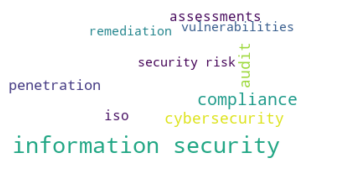

In [22]:
# Show wordcloud
create_wordcloud(topic_model, topic=2)

In [23]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,4051,-1_management_support_development_experience
1,0,836,0_js_web development_spring_design
2,1,748,1_analytics_business_python_techniques
3,2,655,2_information security_compliance_cybersecurit...
4,3,337,3_cisco_configuration_firewalls_vpn
5,4,174,4_jenkins_devops_docker_kubernetes
6,5,167,5_firmware_spi_rtos_microcontrollers
7,6,163,6_engineering business solutions_software deve...
8,7,130,7_simulation_power electronics_circuit design_...
9,8,124,8_project management_scope_budget_stakeholders


In [24]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4051,-1_management_support_development_experience
1,0,836,0_js_web development_spring_design
2,1,748,1_analytics_business_python_techniques
3,2,655,2_information security_compliance_cybersecurit...
4,3,337,3_cisco_configuration_firewalls_vpn
...,...,...,...
242,241,11,241_month end closing_journals_accounts_reconc...
243,242,10,242_hardware_change software_desktop support_t...
244,243,10,243_target profession_bpo recruiters communica...
245,244,10,244_project management_scrum_programs_engineer...


In [25]:
topic_model.get_topic(0)

[('js', 0.007522024832852804),
 ('web development', 0.007092513541770953),
 ('spring', 0.0067658963289872085),
 ('design', 0.006617224605513935),
 ('mysql', 0.006176047528312197),
 ('react', 0.005526845665121834),
 ('html css', 0.004960050974612004),
 ('wordpress', 0.004875045277200356),
 ('mvc', 0.0043630246684561134),
 ('bootstrap', 0.004331321189137002)]

In [26]:
topic_model.get_topic(1)

[('analytics', 0.011836989746505967),
 ('business', 0.00591692264967512),
 ('python', 0.005579733546148009),
 ('techniques', 0.004724836249741304),
 ('ml', 0.004473647060276392),
 ('sql', 0.004300829483347326),
 ('data scientist', 0.004150108559091983),
 ('experience', 0.0034827023724815147),
 ('modeling', 0.003422955761593442),
 ('data mining', 0.003120246473776424)]

In [27]:
topic_model.get_topic(2)

[('information security', 0.012342827932529577),
 ('compliance', 0.0059648254404477295),
 ('cybersecurity', 0.004667875152219946),
 ('audit', 0.004522020167620516),
 ('penetration', 0.004158791426031608),
 ('iso', 0.00381188301903351),
 ('assessments', 0.0037845541944699153),
 ('security risk', 0.0033870772435406343),
 ('remediation', 0.0032344757553676605),
 ('vulnerabilities', 0.0031220619848661194)]

In [28]:
topic_model.get_topic(3)

[('cisco', 0.020858571523775137),
 ('configuration', 0.0070674501226729676),
 ('firewalls', 0.006903613405226487),
 ('vpn', 0.006646926082174704),
 ('protocols', 0.006583730955310824),
 ('routing', 0.006437200042556001),
 ('ccna', 0.006431329038575859),
 ('palo', 0.0060481066260741154),
 ('meraki', 0.0047287253780876285),
 ('network devices', 0.004199634537638174)]

In [29]:
topic_model.get_topic(4)

[('jenkins', 0.018029336497673455),
 ('devops', 0.015353589832190765),
 ('docker', 0.013007705998712158),
 ('kubernetes', 0.011283224232071303),
 ('cicd', 0.009218533531535249),
 ('terraform', 0.006815831832581258),
 ('puppet', 0.004969408293257715),
 ('configuration management', 0.004842111650537145),
 ('gitlab', 0.004450422689816636),
 ('monitoring tools', 0.004324076179254139)]

In [30]:
topic_model.get_topic(5)

[('firmware', 0.015718745777144556),
 ('spi', 0.01487454210724839),
 ('rtos', 0.01461910605195657),
 ('microcontrollers', 0.01210926854676467),
 ('development', 0.011580424201492304),
 ('linux', 0.01140374478641026),
 ('embedded software', 0.009517975508350285),
 ('debugging', 0.0070805052227240935),
 ('i2c', 0.006242490391780038),
 ('git', 0.005649577610467111)]

In [31]:
topic_model.get_topic(6)

[('engineering business solutions', 0.004886985307069679),
 ('software development', 0.004628227644789334),
 ('sensors', 0.004596932741623648),
 ('tools', 0.004293691471656553),
 ('system', 0.0042724458001605885),
 ('technology services engineering', 0.0041400466167605945),
 ('footprint presence', 0.003934680177024677),
 ('subsidiary robert bosch', 0.003934680177024677),
 ('powertrain', 0.0037549912979212953),
 ('test', 0.003729256003681457)]

In [32]:
topic_model.get_topic(7)

[('simulation', 0.009638016793831696),
 ('power electronics', 0.009496134807423106),
 ('circuit design', 0.007465294629775039),
 ('board', 0.007116493563308975),
 ('pcb layout', 0.006895516673177416),
 ('altium', 0.006322175021743446),
 ('pspice', 0.00518062153648619),
 ('emc', 0.00486151236932365),
 ('engineering', 0.004497849804712031),
 ('validation', 0.004402322219286583)]

In [33]:
topic_model.get_topic(8)

[('project management', 0.009203452436061708),
 ('scope', 0.005879762008741151),
 ('budget', 0.005080889487164828),
 ('stakeholders', 0.004663818180152794),
 ('teams', 0.0036387034778401256),
 ('programs', 0.0034531386060624135),
 ('skills', 0.0032016385035148922),
 ('reports', 0.003186927457248861),
 ('project plan', 0.003126190817683686),
 ('objectives', 0.003063007533525539)]

In [34]:
topic_model.get_topic(9)

[('rds', 0.007654200745639648),
 ('terraform', 0.007480187073541044),
 ('devops', 0.007003371550826006),
 ('cicd', 0.005840416884913315),
 ('configuration management', 0.005742912536440479),
 ('monitoring', 0.005502163673426902),
 ('aws services', 0.005233702953289109),
 ('docker', 0.004830332961519593),
 ('vpc', 0.0037985627946104366),
 ('ec', 0.0036784191407828767)]

In [35]:
topic_model.get_topic(10)

[('troubleshooting', 0.02192410505769888),
 ('desktop support', 0.02115254600823424),
 ('technical', 0.01674729599506652),
 ('configuration', 0.012518111987406563),
 ('laptop', 0.010616257562432322),
 ('printers', 0.010161983533189676),
 ('outlook', 0.009193614594600361),
 ('software installation', 0.009133522222945396),
 ('support engineer', 0.009029930126875295),
 ('hardware networking', 0.008331054058029107)]

In [36]:
topic_model.get_topic(11)

[('devops', 0.02126120917513245),
 ('tools', 0.006723883234336518),
 ('cicd', 0.005976287201284688),
 ('deployment', 0.005494116014905496),
 ('kubernetes', 0.003804979535798434),
 ('jenkins', 0.0036089569329946333),
 ('docker', 0.0036065043138856457),
 ('pipelines', 0.0035859973414948333),
 ('configuration management', 0.0035042191607608767),
 ('integration', 0.003317655437227746)]